In [1]:
import mxnet as mx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mxnet import nd
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

C:\Users\lenovo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 用一个高维的线性回归来模拟过拟合，只有20个训练样本

In [2]:
n_train ,n_test,num_inputs = 20,100,200
true_w ,true_b = nd.ones((num_inputs,1),ctx=mx.gpu())*0.01,0.05

In [3]:
features = nd.random.normal(scale=1,shape = (n_train+n_test,num_inputs),ctx = mx.gpu())

In [4]:
labels = nd.dot(features,true_w)+ true_b
labels += nd.random.normal(scale=0.01,shape = labels.shape,ctx = mx.gpu()) 

In [5]:
train_features,test_features = features[:n_train,:],features[n_train:,:]
train_labels,test_labels = labels[:n_train],labels[n_train:]

## 搭建模型初始化参数

In [6]:
def init_param():
    w = nd.random.normal(scale=0.01,shape=(num_inputs,1),ctx=mx.gpu())
    b = nd.zeros(shape = (1,),ctx = mx.gpu())
    
    params = [w,b]
    for param in params:
        param.attach_grad()
    return params

## 搭建模型

In [13]:
def net(X,w,b):
    return nd.dot(X.reshape(-1,num_inputs),w)+b

## 定义L2惩罚项

In [8]:
def l2_penalty(w):
    return (w**2).sum()/2

## 定义损失函数

In [12]:
#平方损失函数
def squared_loss(y_pred,y):
    return ((y_pred-y)**2)/2

## 定义优化器

In [10]:
def sgd(params,batch_size,learning_rate):
    for param in params:
        param[:] = param-param.grad*learning_rate/batch_size

In [11]:
batch_size ,num_epochs,lr = 1,100,0.003
train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),batch_size,shuffle=True)

In [22]:
def semilogy(x_vals,y_vals,x_labels,y_labels,x2_vals=None,y2_vals=None,legend=None,figsize=(3.5,2.5)):
    
    plt.figure(figsize=figsize)
    plt.xlabel(x_labels)
    plt.ylabel(y_labels)
    plt.semilogy(x_vals,y_vals)
    
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals,y2_vals,linestyle=':')
        plt.legend(legend)

In [17]:
def fit_and_plot(lambd):
    w,b = init_param()  #获取模型参数
    train_loss=[]
    test_loss =[]
    for epoch in range(1,num_epochs+1):
        for X,y in train_iter:
            with autograd.record():
                y_pred = net(X,w,b)           
                l = squared_loss(y_pred,y) + lambd*l2_penalty(w)
            l.backward()
            sgd([w,b],batch_size,lr)
        train_loss.append(squared_loss(net(train_features,w,b),train_labels).mean().asscalar())
        test_loss.append(squared_loss(net(test_features,w,b),test_labels).mean().asscalar())
        
    
    #下面进行绘图
    semilogy(range(1,num_epochs+1),train_loss,'epochs','loss',range(1,num_epochs+1),test_loss,
            ['train_loss','test_loss'])
    print('L2 norm of w:', w.norm().asscalar())

L2 norm of w: 0.13737884


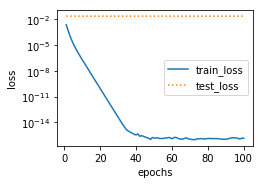

In [23]:
fit_and_plot(lambd = 0)

L2 norm of w: 0.025062345


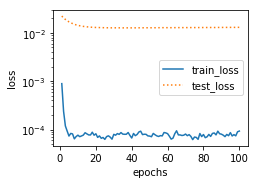

In [24]:
fit_and_plot(lambd = 2)

L2 norm of w: 0.021856852


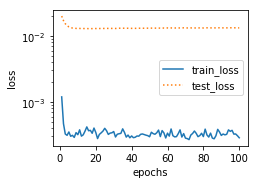

In [25]:
fit_and_plot(lambd = 5)

L2 norm of w: 0.024045309


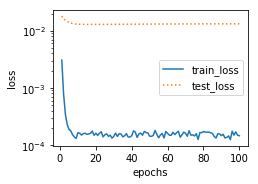

In [26]:
fit_and_plot(lambd = 3)

## gluon接口实现 通过优化器 'wd'来设置衰减参数

In [32]:
loss = gloss.L2Loss()

def fit_and_plot_gluon(lambd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1),ctx = mx.gpu())
    
    trainer_w = gluon.Trainer(net.collect_params('.*weight'),'sgd',
                             {'learning_rate':lr,'wd':lambd})
    trainer_b =gluon.Trainer(net.collect_params('.*bias'),'sgd',
                            {'learning_rate':lr})
    train_ls,test_ls = [],[]
    
    for _ in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X),y)
            l.backward()
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        
        train_ls.append(loss(net(train_features),train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),test_labels).mean().asscalar())
        
    
    #绘图
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:'+str(net[0].weight.data().norm().asscalar()))

L2 norm of w:13.115853


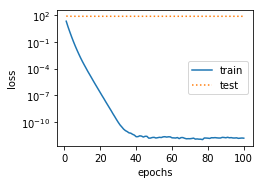

In [33]:
fit_and_plot_gluon(0)

L2 norm of w:0.026388168


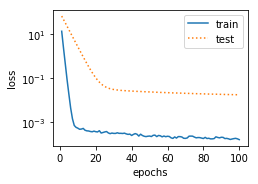

In [34]:
fit_and_plot_gluon(3)